# Descripción del Ejercicio 
Has recibido una tarea analítica de una tienda en línea internacional. Tus predecesores no consiguieron completarla: lanzaron una prueba A/B y luego abandonaron (para iniciar una granja de sandías en Brasil). Solo dejaron las especificaciones técnicas y los resultados de las pruebas.

# Descripción Técnica 
- Nombre de la prueba: `recommender_system_test`
- Grupos: А (control), B (nuevo embudo de pago)
- Launch date: 2020-12-07
- Fecha en la que dejaron de aceptar nuevos usuarios: 2020-12-21
- Fecha de finalización: 2021-01-01
- Audiencia: 15% de los nuevos usuarios de la región de la UE
- Propósito de la prueba: probar cambios relacionados con la introducción de un sistema de recomendaciones mejorado
- Resultado esperado: dentro de los 14 días posteriores a la inscripción, los usuarios mostrarán una mejor conversión en vistas de la página del producto (el evento `product_page`), instancias de agregar artículos al carrito de compras (`product_card`) y compras (`purchase`). En cada etapa del embudo `product_page → product_card → purchase`, habrá al menos un 10% de aumento.
- Número previsto de participantes de la prueba: 6 000


# Instrucciones a seguir 
- Describe los objetivos del estudio.
- Explora los datos:
    - ¿Es necesario convertir los tipos?
    - ¿Hay valores ausentes o duplicados? Si es así, ¿cómo los caracterizarías?
- Lleva a cabo el análisis exploratorio de datos:
    - Estudia la conversión en las diferentes etapas del embudo.
    - ¿El número de eventos por usuario está distribuido equitativamente entre las muestras?
    - ¿Hay usuarios que están presentes en ambas muestras?
    - ¿Cómo se distribuye el número de eventos entre los días?
    - ¿Hay alguna peculiaridad en los datos que hay que tener en cuenta antes de iniciar la prueba A/B?
- Evaluar los resultados de la prueba A/B:
    - ¿Qué puedes decir sobre los resultados de la prueba A/B?
    - Utiliza una prueba z para comprobar la diferencia estadística entre las proporciones
- Describe tus conclusiones con respecto a la etapa EDA y los resultados de la prueba A/B

# Importar Librerías 


In [135]:
# Librerías para la manipulación de datosm
import pandas as pd 
import numpy as np 
import math 
import datetime as dt 
# Librerías para el estudio estadístico 
from scipy import stats as st 
from statsmodels.stats.proportion import proportions_ztest
# Librerías para la visualización de datos  
import seaborn as sns 
import matplotlib.pyplot as plt 

# Importar datasets 

In [136]:
# Calendario de eventos de marketing 
marketing_events = pd.read_csv('/datasets/ab_project_marketing_events_us.csv')
# Usuarios que se registraron 
users = pd.read_csv('f/datasets/final_ab_new_users_upd_us.csv')
# Evento de los usuarios 
events = pd.read_csv('/datasets/final_ab_events_upd_us.csv')
# Datos de los participantes de la prueba 
user_data = pd.read_csv('/datasets/final_ab_participants_upd_us.csv')

# Descripción de los datos 
- `marketing_events`: el calendario de eventos de marketing para 2020
- `users`: todos los usuarios que se registraron en la tienda en línea desde el 7 hasta el 21 de diciembre de 2020
- `events`: todos los eventos de los nuevos usuarios en el período comprendido entre el 7 de diciembre de 2020 y el 1 de enero de 2021
- `user_data`: tabla con los datos de los participantes de la prueba

## Marketing Events 
- `name`: el nombre del evento de marketing
- `regions`: regiones donde se llevará a cabo la campaña publicitaria
- `start_dt`: fecha de inicio de la campaña
- `finish_dt`: fecha de finalización de la campaña

In [137]:
marketing_events

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11
5,Black Friday Ads Campaign,"EU, CIS, APAC, N.America",2020-11-26,2020-12-01
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11


## Users
- `user_id`
- `first_date`: fecha de inscripción
- `region`
- `device`: dispositivo utilizado para la inscripción

In [138]:
users.head(10)

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone
5,137119F5A9E69421,2020-12-07,N.America,iPhone
6,62F0C741CC42D0CC,2020-12-07,APAC,iPhone
7,8942E64218C9A1ED,2020-12-07,EU,PC
8,499AFACF904BBAE3,2020-12-07,N.America,iPhone
9,FFCEA1179C253104,2020-12-07,EU,Android


## Events 
- `user_id`
- `event_dt`: fecha y hora del evento
- `event_name`: nombre del tipo de evento
- `details`: datos adicionales sobre el evento (por ejemplo, el pedido total en USD para los eventos `purchase`)

In [139]:
events.head(10)

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99
5,831887FE7F2D6CBA,2020-12-07 06:50:29,purchase,4.99
6,6B2F726BFD5F8220,2020-12-07 11:27:42,purchase,4.99
7,BEB37715AACF53B0,2020-12-07 04:26:15,purchase,4.99
8,B5FA27F582227197,2020-12-07 01:46:37,purchase,4.99
9,A92195E3CFB83DBD,2020-12-07 00:32:07,purchase,4.99


## User Data 
- `user_id`
- `ab_test`: nombre de la prueba
- `group`: el grupo de prueba al que pertenecía el usuario

In [140]:
user_data.head(10)

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,4FF2998A348C484F,A,recommender_system_test
5,7473E0943673C09E,A,recommender_system_test
6,C46FE336D240A054,A,recommender_system_test
7,92CB588012C10D3D,A,recommender_system_test
8,B3A2485649E4A012,A,recommender_system_test
9,66FC298441D50783,A,recommender_system_test


# Preprocesamiento de Datos 

## Valores Ausentes 

### Marketing Events 


In [141]:
marketing_events.isna().sum()

name         0
regions      0
start_dt     0
finish_dt    0
dtype: int64

El dataset no muestra ningún valor ausente 

### Users 

In [142]:
users.isna().sum()

user_id       0
first_date    0
region        0
device        0
dtype: int64

El dataset no muestra ningún valor ausente 

### Events 


In [143]:
events.isna().sum()

user_id            0
event_dt           0
event_name         0
details       363447
dtype: int64

El dataset muestra una gran cantidad de valores ausentes en la columna `details`, sin embargo estos datos solamente dan información adicional para los diferentes eventos del dataset y el eliminarlos nos haría perder información muy importante para el estudio del embudo, por lo que no se eliminarán 

### User Data


In [144]:
user_data.isna().sum()

user_id    0
group      0
ab_test    0
dtype: int64

El dataset no muestra ningún valor ausente 

## ¿Es necesario convertir los datos?


Utilizar la información general de los datasets para ver el tipo de datos actuales y tomar decisiones en base a el

### Marketing Events


In [145]:
marketing_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 580.0+ bytes


Las columnas referentes a las fechas de inicio y final deberían ser tipo datetime, pero son de tipo object y por esa razón se pasarán a tipo datetime

In [146]:
# Convertir a tipo datetime
marketing_events['start_dt'] = pd.to_datetime(marketing_events['start_dt'])
marketing_events['finish_dt'] = pd.to_datetime(marketing_events['finish_dt'])

### Users

In [147]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58703 entries, 0 to 58702
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     58703 non-null  object
 1   first_date  58703 non-null  object
 2   region      58703 non-null  object
 3   device      58703 non-null  object
dtypes: object(4)
memory usage: 1.8+ MB


In [148]:
# Convertir a tipo datetime 
users['first_date'] = pd.to_datetime(users['first_date'])

### Events 

In [149]:
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 423761 entries, 0 to 423760
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     423761 non-null  object 
 1   event_dt    423761 non-null  object 
 2   event_name  423761 non-null  object 
 3   details     60314 non-null   float64
dtypes: float64(1), object(3)
memory usage: 12.9+ MB


In [150]:
# Convertir a tipo datetime 
events['event_dt'] = pd.to_datetime(events['event_dt'])

### User Data 

In [151]:
user_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14525 entries, 0 to 14524
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  14525 non-null  object
 1   group    14525 non-null  object
 2   ab_test  14525 non-null  object
dtypes: object(3)
memory usage: 340.6+ KB


## Valores Duplicados 



### Marketing Events 


In [152]:
marketing_events.duplicated().sum()

0

### Users 

In [153]:
users.duplicated().sum()

0

### Events 

In [154]:
events.duplicated().sum()

0

### User Data 


In [155]:
user_data.duplicated().sum()

0

# Análisis Exploratorio de Datos 
Antes de iniciar este analisis exploratorio, es importante crear un dataframe que contenga toda la informacion de los usuarios, para ello ocuparemos los df 'users', 'events' y 'user_data'

## Unir la info de todos los usuarios en un solo DF

In [156]:
test_data = users.merge(events, on='user_id', how='left').merge(user_data, on='user_id', how='left')
# Ver Informacion General 
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 429476 entries, 0 to 429475
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     429476 non-null  object        
 1   first_date  429476 non-null  datetime64[ns]
 2   region      429476 non-null  object        
 3   device      429476 non-null  object        
 4   event_dt    429476 non-null  datetime64[ns]
 5   event_name  429476 non-null  object        
 6   details     61134 non-null   float64       
 7   group       102838 non-null  object        
 8   ab_test     102838 non-null  object        
dtypes: datetime64[ns](2), float64(1), object(6)
memory usage: 29.5+ MB


Vemos que el DF resultante tiene demasiados valores ausentes en las columnas referentes a la prueba A/B, como lo son: 'group' y 'ab_test', por lo que se eliminaran los valores ausentes de estas columnas ya que son de usuarios que no estan registrados en ningun grupo de la prueba

In [157]:
test_data.dropna(subset='group', inplace=True)
# Agregar una columna con unicamente la fecha 
test_data['date'] = pd.to_datetime(test_data['event_dt'].dt.date)

Antes de continuar es importante separar el DF en los grupos A y B para poder hacer comparaciones entre ambos y valorar los resultados de la prueba A/B 

In [158]:
# Separar el DF en los dos grupos 

group_A = test_data[test_data['group']=='A'] # Filtrar los datos con la informacion de los usuarios del grupo A
group_B = test_data[test_data['group']=='B'] # Filtrar los datos con la informacion de los usuarios del grupo B

In [159]:
group_A.info() 

<class 'pandas.core.frame.DataFrame'>
Index: 58705 entries, 0 to 429345
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     58705 non-null  object        
 1   first_date  58705 non-null  datetime64[ns]
 2   region      58705 non-null  object        
 3   device      58705 non-null  object        
 4   event_dt    58705 non-null  datetime64[ns]
 5   event_name  58705 non-null  object        
 6   details     8619 non-null   float64       
 7   group       58705 non-null  object        
 8   ab_test     58705 non-null  object        
 9   date        58705 non-null  datetime64[ns]
dtypes: datetime64[ns](3), float64(1), object(6)
memory usage: 4.9+ MB


## Conversión en las diferentes etapas del embudo 

In [160]:
# Ver los eventos posibles 
print(test_data['event_name'].unique())

['product_page' 'login' 'product_cart' 'purchase']


Los 4 eventos registrados son:
+ Login
+ Product Page   
+ Product Cart 
+ Purchase 

El sentido logico del embudo seria el siguiente:

Los usuarios al llegar por primera vez van a la pagina 'Login', luego de registrarse o iniciar sesion van a 'Product Page', en el caso que les agrade un producto agregan este al carrito, por lo que la siguiente etapa del embudo es en 'Product Cart' y por ultimo la pagina 'Purchase'. Esto nos deja un total de 3 etapas en el embudo

In [161]:
'''  
Para calcular la conversion en las diferentes etapas es necesario saber cuantos usuarios se han registrado en cada evento. 
Agruparemos los datos para ambas muestras y calcularemos los usuarios unicos registrados. 
'''
# Calcular los usuarios por evento del grupo A 
user_per_event_A = group_A.groupby('event_name', as_index=False)['user_id'].nunique().sort_values(by='user_id',ascending=False)
# Renombrar columnas  
user_per_event_A.columns = ['event_name','users_count']
# Calcular los usuarios por evento del grupo B 
user_per_event_B = group_B.groupby('event_name', as_index=False)['user_id'].nunique().sort_values(by='user_id',ascending=False)
# Renombrar columnas 
user_per_event_B.columns = ['event_name','users_count']

### Conversion en las etapas del embudo en el grupo A

In [162]:
login_to_product_A = round((int(user_per_event_A['users_count'][user_per_event_A['event_name']=='product_page']) / int(user_per_event_A['users_count'][user_per_event_A['event_name']=='login']))*100,2)
product_to_cart_A = round((int(user_per_event_A['users_count'][user_per_event_A['event_name']=='product_cart']) / int(user_per_event_A['users_count'][user_per_event_A['event_name']=='product_page']))*100,2)
cart_to_purchase_A = round((int(user_per_event_A['users_count'][user_per_event_A['event_name']=='purchase']) / int(user_per_event_A['users_count'][user_per_event_A['event_name']=='product_cart']))*100,2)

C:\Users\User\AppData\Local\Temp\ipykernel_19688\4211925170.py:1: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  login_to_product_A = round((int(user_per_event_A['users_count'][user_per_event_A['event_name']=='product_page']) / int(user_per_event_A['users_count'][user_per_event_A['event_name']=='login']))*100,2)
C:\Users\User\AppData\Local\Temp\ipykernel_19688\4211925170.py:2: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  product_to_cart_A = round((int(user_per_event_A['users_count'][user_per_event_A['event_name']=='product_cart']) / int(user_per_event_A['users_count'][user_per_event_A['event_name']=='product_page']))*100,2)
C:\Users\User\AppData\Local\Temp\ipykernel_19688\4211925170.py:3: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Us

In [163]:
login_to_product_A, product_to_cart_A, cart_to_purchase_A

(66.15, 47.68, 108.01)

### Conversion en las etapas del embudo en el grupo B

In [164]:
login_to_product_B = round((int(user_per_event_B['users_count'][user_per_event_B['event_name']=='product_page']) / int(user_per_event_B['users_count'][user_per_event_B['event_name']=='login'])) * 100,2)
product_to_cart_B = round((int(user_per_event_B['users_count'][user_per_event_B['event_name']=='product_cart']) / int(user_per_event_B['users_count'][user_per_event_B['event_name']=='product_page'])) * 100,2)
cart_to_purchase_B = round((int(user_per_event_B['users_count'][user_per_event_B['event_name']=='purchase']) / int(user_per_event_B['users_count'][user_per_event_B['event_name']=='product_cart'])) * 100,2)

C:\Users\User\AppData\Local\Temp\ipykernel_19688\4162439894.py:1: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  login_to_product_B = round((int(user_per_event_B['users_count'][user_per_event_B['event_name']=='product_page']) / int(user_per_event_B['users_count'][user_per_event_B['event_name']=='login'])) * 100,2)
C:\Users\User\AppData\Local\Temp\ipykernel_19688\4162439894.py:2: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  product_to_cart_B = round((int(user_per_event_B['users_count'][user_per_event_B['event_name']=='product_cart']) / int(user_per_event_B['users_count'][user_per_event_B['event_name']=='product_page'])) * 100,2)
C:\Users\User\AppData\Local\Temp\ipykernel_19688\4162439894.py:3: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future

In [165]:
login_to_product_B, product_to_cart_B, cart_to_purchase_B

(64.25, 51.1, 98.58)

Interpretación:

+ El grupo A muestra una conversión ligeramente mayor en la etapa de Login to Product Page y Cart to Purchase, mientras que el grupo B tiene una conversión mayor en la etapa de Product 
Page to Cart.
+ En general, ambas conversiones son bastante similares, con diferencias relativamente pequeñas.

## Eventos por usuario 


In [166]:
# Calcular los eventos de cada usuario en el grupo A
event_per_user_A = group_A.groupby('user_id')['event_name'].count().reset_index()
# Calcular los eventos de cada usuario en el grupo B
event_per_user_B = group_B.groupby('user_id')['event_name'].count().reset_index()

In [167]:
# Ver estadisticas descriptivas de los eventos por usuario del grupo A 
event_per_user_A.describe()

,event_name
count,7874.000000
mean,7.455550
std,4.475159
min,1.000000
25%,4.000000
50%,6.000000
75%,9.000000
max,40.000000


In [168]:
# Ver estadisticas descriptivas de los eventos por usuario del grupo B
event_per_user_B.describe()

,event_name
count,6205.000000
mean,7.112490
std,4.246201
min,1.000000
25%,4.000000
50%,6.000000
75%,9.000000
max,36.000000


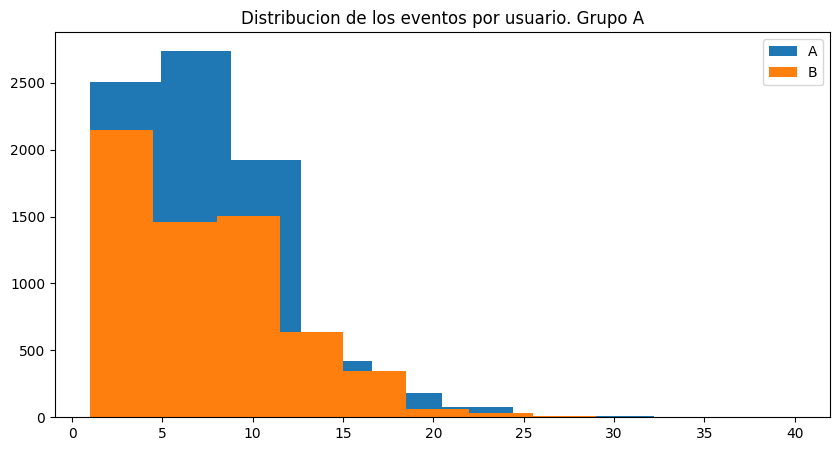

In [169]:
plt.figure(figsize=(10,5))
plt.hist(event_per_user_A['event_name'], label='A')
plt.hist(event_per_user_B['event_name'], label='B')
plt.title('Distribucion de los eventos por usuario. Grupo A')
plt.legend()
plt.show()

+ La media de eventos por usuario es similar en ambos grupos, siendo ligeramente superior en el grupo A (7.46) comparado con el grupo B (7.11).
+ La distribución de eventos parece bastante equitativa, con rangos y percentiles similares, indicando que ambos grupos tienen comportamientos de uso similares en términos de eventos por usuario.

## ¿Hay usuarios que están presentes en ambas muestras?

In [170]:
# Agrupar a los usuarios con la cantidad unica de grupos a los que pertenecen de forma descendente 
double_group = test_data.groupby('user_id')['group'].nunique().sort_values(ascending=False)

In [171]:
# Guardar los usuarios en dos grupos de una lista 
doubles = double_group.index[double_group==2].tolist()

In [172]:
# Sacar a los usuarios con dos grupos del DF 
test_data = test_data[~test_data['user_id'].isin(doubles)]

In [173]:
# Filtrar los usuarios del grupo A de aquellos que estan en ambos grupos 
group_A = group_A[~group_A['user_id'].isin(doubles)]
# Filtrar los usuarios del grupo A de aquellos que estan en ambos grupos 
group_B = group_B[~group_B['user_id'].isin(doubles)]

## Distribucion del numero de eventos entre los dias 


In [174]:
events_per_day_A = group_A.groupby('date', as_index=False)['event_name'].count()
events_per_day_A.columns = ['date','events_count']
events_per_day_B = group_B.groupby('date', as_index=False)['event_name'].count()
events_per_day_B.columns = ['date','events_count']

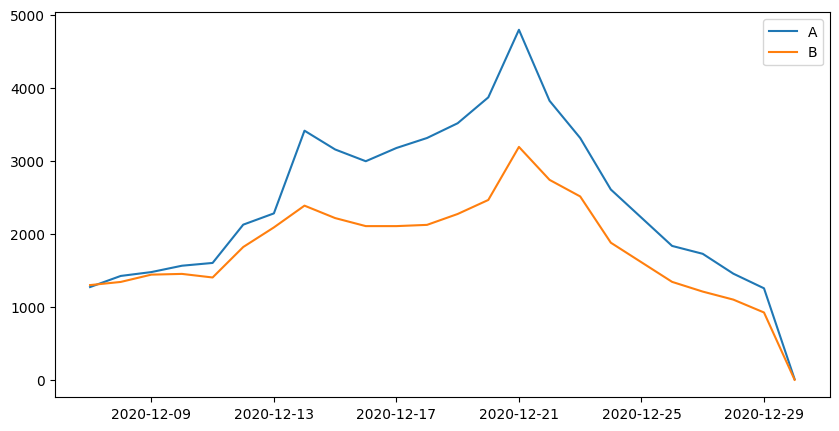

In [175]:
plt.figure(figsize=(10,5))
plt.plot(events_per_day_A['date'], events_per_day_A['events_count'], label='A')
plt.plot(events_per_day_B['date'], events_per_day_B['events_count'], label='B')
plt.legend()
plt.show()

Grupo A:

Los eventos diarios varían considerablemente, con un pico notable el 21 de diciembre (4794 eventos).

Otros días con alta actividad incluyen el 14 de diciembre (3413 eventos) y el 20 de diciembre (3869 eventos).

Grupo B:

Similar al grupo A, el 21 de diciembre muestra un pico de actividad (3191 eventos).

Otros días con alta actividad incluyen el 14 de diciembre (2387 eventos) y el 20 de diciembre (2465 eventos).

Interpretación:

+ Ambos grupos muestran picos de actividad en fechas similares, lo que podría indicar la influencia de campañas de marketing o promociones especiales en esos días.
+ La distribución general de eventos a lo largo de los días es consistente entre ambos grupos, lo que sugiere que los eventos externos que afectan a un grupo también afectan al otro de manera similar.
+ Ambos grupos muestran una gran caida a medida se va acabando la prueba A/B, esto podria implicar que las campanas realizadas en estas fechas no fueron exitosas/rentables y que el grupo B no mostro una diferencia notable en su comportamiento en comparacion con el grupo A

# Prueba A/B

## Utilizar prueba A/B para comprobar la diferencia entre las proporciones

In [184]:
user_per_event_B
def test(df_1,df_2,previous_event,event):
    total1 = df_1[df_1['event_name'] == previous_event]['users_count'].iloc[0]
    successes1 = df_1[df_1['event_name'] == event]['users_count'].iloc[0]
    
    total2 = df_2[df_2['event_name'] == previous_event]['users_count'].iloc[0]
    successes2 = df_2[df_2['event_name'] == event]['users_count'].iloc[0]
    
    z_stat, p_value = proportions_ztest([successes1,successes2],[total1,total2])
    # Determinar si hay una diferencia estadísticamente significativa
    if p_value < 0.05:
        result = f"Hay una diferencia estadísticamente significativa entre los grupos para el evento '{event}'."
    else:
        result = f"No hay evidencia suficiente para afirmar que hay una diferencia estadísticamente significativa entre los grupos para el evento '{event}'."

    return result

In [187]:
print(f'Resultado de la prueba para la primera etapa: \n {test(user_per_event_A,user_per_event_B,"login","product_page")}')
print()
print(f'Resultado de la prueba para la primera etapa: \n {test(user_per_event_A,user_per_event_B,"product_page","product_cart")}')
print()
print(f'Resultado de la prueba para la primera etapa: \n {test(user_per_event_A,user_per_event_B,"product_cart","purchase")}')

Resultado de la prueba para la primera etapa: 
 Hay una diferencia estadísticamente significativa entre los grupos para el evento 'product_page'.

Resultado de la prueba para la primera etapa: 
 Hay una diferencia estadísticamente significativa entre los grupos para el evento 'product_cart'.

Resultado de la prueba para la primera etapa: 
 No hay evidencia suficiente para afirmar que hay una diferencia estadísticamente significativa entre los grupos para el evento 'purchase'.


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\stats\proportion.py:1025: RuntimeWarning: invalid value encountered in sqrt
  std_diff = np.sqrt(var_)


Conclusiones sobre los Resultados de la Prueba Z

Resultados de la Prueba Z:

Primera Etapa: Login to Product Page

Hay una diferencia estadísticamente significativa entre los grupos para el evento product_page.

Segunda Etapa: Product Page to Cart

Hay una diferencia estadísticamente significativa entre los grupos para el evento product_cart.

Tercera Etapa: Cart to Purchase

No hay evidencia suficiente para afirmar que hay una diferencia estadísticamente significativa entre los grupos para el evento purchase.

Interpretación de los Resultados:

1. Primera Etapa: Login to Product Page

Significado: La diferencia significativa en la primera etapa indica que el nuevo sistema de recomendaciones del grupo B está afectando de manera significativa la tasa de conversión de Login to Product Page.

Implicación: Los usuarios en el grupo B, con el nuevo sistema de recomendaciones, tienen una diferente (mejor o peor, según el sentido del z-score) probabilidad de visitar la página del producto después de iniciar sesión en comparación con el grupo A.

2. Segunda Etapa: Product Page to Cart

Significado: La diferencia significativa en la segunda etapa sugiere que el nuevo sistema de recomendaciones también impacta significativamente la tasa de conversión de Product Page to Cart.

Implicación: El sistema de recomendaciones está afectando cómo los usuarios pasan de ver una página de producto a agregar productos al carrito. Este impacto puede ser positivo (mejor conversión) o negativo (peor conversión) dependiendo del signo del z-score.

3. Tercera Etapa: Cart to Purchase

Significado: La falta de diferencia significativa en la tercera etapa sugiere que el nuevo sistema de recomendaciones no tiene un impacto estadísticamente significativo en la tasa de conversión de Cart to Purchase.

Implicación: Aunque los usuarios en el grupo B pueden estar más o menos inclinados a agregar productos al carrito, esto no se traduce en una diferencia significativa en las compras finales. Esto indica que el nuevo sistema de recomendaciones no mejora ni empeora significativamente la conversión final en la etapa de compra.

Conclusiones Generales:

Impacto en las Primeras Etapas:

El nuevo sistema de recomendaciones tiene un impacto significativo en las primeras dos etapas del embudo (Login to Product Page y Product Page to Cart). Esto puede implicar que el sistema está influenciando cómo los usuarios interactúan con las páginas de productos y deciden agregar productos al carrito.

Falta de Impacto en la Compra Final:

La ausencia de una diferencia significativa en la etapa final (Cart to Purchase) sugiere que, aunque el sistema puede influir en las decisiones intermedias, no logra impactar la decisión de compra final. Este es un hallazgo crucial, ya que el objetivo final de cualquier mejora en el embudo de conversión es aumentar las ventas.

Consideraciones para la Implementación:

Dado que el nuevo sistema de recomendaciones no mejora la conversión final de Cart to Purchase, su implementación debe ser reconsiderada. Podría ser beneficioso realizar ajustes adicionales al sistema de recomendaciones para mejorar su efectividad en la etapa final del embudo.

Análisis Adicional:

Realizar un análisis cualitativo para entender por qué los usuarios con el nuevo sistema de recomendaciones no están completando más compras puede proporcionar insights valiosos. Entrevistas de usuarios, análisis de comportamiento y mapas de calor pueden ayudar a identificar barreras en la etapa final.

Recomendaciones:

Mejorar el Sistema de Recomendaciones:

Revisar y ajustar el sistema de recomendaciones para abordar específicamente la etapa de Cart to Purchase.
Considerar la implementación de incentivos o recordatorios para los usuarios que agregan productos al carrito pero no completan la compra.


## ¿Qué se decir sobre los resultados de la prueba A/B?
En conclusión, el análisis de la prueba A/B realizada para evaluar el nuevo sistema de recomendaciones ha revelado varios hallazgos clave. A pesar de observar diferencias significativas en las etapas iniciales del embudo de conversión, estas diferencias no se mantuvieron en la etapa final de Cart to Purchase. Esto sugiere que el nuevo sistema de recomendaciones influye en el comportamiento de navegación y la intención de compra, pero no se traduce en un aumento significativo en las conversiones finales. Además, la disminución de eventos hacia el final del período de prueba podría indicar factores externos o una falta de interés sostenido por parte de los usuarios. Dado que el objetivo principal de cualquier sistema de recomendaciones es mejorar las ventas finales, y el grupo B no ha mostrado una mejora clara en este aspecto en comparación con el grupo A, no es recomendable continuar con esta implementación sin realizar ajustes significativos. Se recomienda realizar mejoras en el sistema de recomendaciones basadas en los insights obtenidos, implementar estrategias adicionales para mantener el interés del usuario y considerar realizar nuevas pruebas A/B con estos cambios antes de una implementación completa.
